In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline

## 读取数据

In [14]:
# Read Dataset
data = pd.read_csv('../../data/abcnews-date-text.csv', usecols=['headline_text'])
data = data.head(10000)  # 这里只获取部分数据
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   headline_text  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [15]:
data

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers
...,...
9995,us units attack palace as fighting rages in heart
9996,vasco win 10 goal thriller in brazil on edmundos
9997,vic bushfires inquiry begins
9998,vic govt plan aims to reduce water use


In [16]:
data[data['headline_text'].duplicated(keep=False)].sort_values('headline_text')

,headline_text
9256,5 australian sars cases being monitored
9461,5 australian sars cases being monitored
6404,all walks of life follow protest path
6194,all walks of life follow protest path
6199,asio briefs crean on terrorist risk
...,...
6398,wildcats crush hawks
6598,wildcats crush hawks
5511,woman dies in car crash
5031,woman dies in car crash


In [17]:
data = data.drop_duplicates()
data

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers
...,...
9995,us units attack palace as fighting rages in heart
9996,vasco win 10 goal thriller in brazil on edmundos
9997,vic bushfires inquiry begins
9998,vic govt plan aims to reduce water use


## 数据预处理

In [18]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
print(stop_words)
print(type(stop_words))
desc = data['headline_text'].values

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(desc)
X

frozenset({'always', 'side', 'ie', 'only', 'within', ']', 'can', 'afterwards', 'very', 'whenever', 'sincere', 'empty', 'became', 'besides', 'that', 'everywhere', 'take', 'and', 'cannot', 'less', 'please', 'even', 'some', 'we', 'all', 'hundred', 'own', 'couldnt', 'seems', 'was', 'everything', 'my', 'twenty', 'nor', 'whence', 'under', 'himself', 'into', 'onto', 'anywhere', 'co', 'out', 'former', ':', 'etc', 'might', 'it', 'becomes', 'anything', 'first', 'interest', 'few', 'thereby', 'latterly', '{', 'keep', '%', 'whether', 'the', 'somewhere', 'else', 'detail', 'whither', 'mill', 'three', 'could', 'five', 'am', 'mostly', 'again', 'whereby', 'thereupon', 'once', 'none', 'serious', 'yourself', 'between', 'when', 'you', 'amoungst', 'your', 'becoming', 'twelve', 'i', 'inc', 'yet', 'not', 'fire', 'herself', 'otherwise', 'thereafter', 'nevertheless', 'sometimes', 'last', 'made', 'already', 'around', 'thus', 'hasnt', 'because', 'after', 'as', 'without', 'nowhere', 'describe', 'get', 'is', 'perha

<9967x10050 sparse matrix of type '<class 'numpy.float64'>'
	with 63639 stored elements in Compressed Sparse Row format>

In [19]:
word_features = vectorizer.get_feature_names()
print(len(word_features))
print(word_features[5000: 5100])

10050
['killings', 'kills', 'kily', 'kimberley', 'kindred', 'king', 'kingfish', 'kingfisher', 'kings', 'kingstream', 'kingz', 'kirilenko', 'kirkuk', 'kirsten', 'kirwan', 'kit', 'kits', 'kitty', 'kivilev', 'kivilevs', 'kiwi', 'kiwis', 'klim', 'klims', 'klitschko', 'klusener', 'km', 'knee', 'knife', 'knights', 'knives', 'knock', 'knocked', 'knocking', 'knopfler', 'know', 'knowles', 'known', 'koala', 'koalas', 'koen', 'kong', 'kookaburras', 'korea', 'korean', 'koreans', 'koreas', 'kosciuszko', 'kosmina', 'kournikova', 'krakow', 'kravitz', 'krige', 'kroger', 'kucera', 'kuerten', 'kununurra', 'kuranyi', 'kurd', 'kurdish', 'kurds', 'kuwait', 'kuwaiti', 'kwan', 'kyi', 'kylie', 'kyoto', 'kyrgyzstan', 'la', 'label', 'labels', 'labor', 'laboratories', 'labors', 'labour', 'lack', 'laden', 'ladens', 'ladies', 'lag', 'lagoon', 'lagoons', 'lags', 'laid', 'lake', 'lakers', 'lakes', 'lambie', 'laments', 'land', 'landfill', 'landholder', 'landholders', 'landing', 'landmine', 'landmines', 'lands', 'land

E:\PySoft\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Tokenizing
将句子分解为单词和标点符号

### 使用停用词stemming和自定义的tokenizing进行TFIDF向量化

In [20]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return np.asarray([' '.join(tokenizer.tokenize(' '.join([stemmer.stem(i) for i in j.split(' ')]))) for j in text], dtype=object)

In [21]:
print(tokenize(desc))

['aba decid against communiti broadcast licenc'
 'act fire wit must be awar of defam'
 'a g call for infrastructur protect summit' ...
 'vic bushfir inquiri begin' 'vic govt plan aim to reduc water use'
 'vic govt urg to green light marina plan']


In [22]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(tokenize(desc))

# print(X)
print(vectorizer.get_feature_names()[:50])

['aa', 'aac', 'ab', 'aba', 'abalon', 'abandon', 'abar', 'abattoir', 'abbott', 'abc', 'abdic', 'abduct', 'abid', 'abigroup', 'abil', 'abl', 'ablaz', 'aboard', 'abolit', 'aborigin', 'abort', 'abov', 'abreast', 'abroad', 'absenc', 'absent', 'abu', 'abund', 'abus', 'abysm', 'ac', 'aca', 'academ', 'academi', 'acapulco', 'acb', 'accc', 'accent', 'accept', 'access', 'accid', 'accident', 'accommod', 'account', 'accredit', 'accus', 'ace', 'aceh', 'achiev', 'acid']


## K-Means 聚类

使用手肘法选择聚类簇的数量

>随着聚类数k的增大,样本划分会更加的精细,每个簇的聚合程度会逐渐提高,那么误差平方和SSE自然会逐渐变小,并且当k小于真实的簇类数时,由于k的增大会大幅增加每个簇的聚合程度,因此SSE的下降幅度会很大,而当k到达真实聚类数时,再增加k所得到的聚合程度回报会迅速变小,所以SSE的下降幅度会骤减,然后随着k值的继续增大而趋于平缓,也就是说SSE和k的关系类似于手肘的形状,而这个肘部对应的k值就是数据的真实聚类数.因此这种方法被称为手肘法.

100%|██████████| 10/10 [02:40<00:00, 16.08s/it]


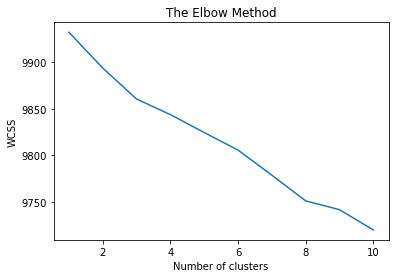

In [25]:
wcss = []
for i in tqdm(range(1,11), colour='cyan'):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.savefig('elbow.png')
plt.show()

In [29]:
cluster_center = 5
kmeans = KMeans(n_clusters=cluster_center)
kmeans.fit(X)

output = pd.DataFrame(desc, columns=['headline_text'])
output['category'] = kmeans.labels_
output.head(500)

,headline_text,category
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,0
2,a g calls for infrastructure protection summit,0
3,air nz staff in aust strike for pay rise,0
4,air nz strike to affect australian travellers,0
...,...,...
9962,us units attack palace as fighting rages in heart,0
9963,vasco win 10 goal thriller in brazil on edmundos,0
9964,vic bushfires inquiry begins,0
9965,vic govt plan aims to reduce water use,0


,headline_text,category
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,0
2,a g calls for infrastructure protection summit,0
3,air nz staff in aust strike for pay rise,0
4,air nz strike to affect australian travellers,0
...,...,...
495,claims live sheep cattle exports threatening tas,0
496,claims more rain will boost stock prices,0
497,class action may cost esso 50m,0
498,clinton cancels trip to india,0
